In [1]:
import cvxpy as cp 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
def solver(x0, xf, tf, r, obs, dt, last_x, R):
    T = int(tf/dt)
    x = cp.Variable((len(x0), T+1))
    u = cp.Variable((2, T))
    A = np.array([[1., dt, 0., 0.], 
                  [0., 1., 0., 0.],
                  [0., 0., 1., dt], 
                  [0., 0., 0., 1.]])
    B = np.array([[0., 0.], [dt, 0.],
                  [0., 0.], [0., dt]])

    objective = cp.Minimize(cp.sum_squares(u))    
    constraints = [x[:, 0] == x0, x[:, T] == xf] # state constraints
    
    # dynamics, input and safety constraints
    for t in range(0, T):
        constraints.append( x[:, t+1] == A @ x[:, t] + B @ u[:, t] )
        constraints.append( u[:, t] <= np.array([1., 1.]) )
        constraints.append( u[:, t] >= -np.array([1., 1.]) )
        pos1 = x[[0, 2], t+1] - obs
        pos2 = last_x[[0, 2], t+1] - obs
        constraints.append( pos1 @ pos2 >= r*np.linalg.norm(pos2) )
        # trust region
        constraints.append( cp.norm(x[:, t+1]-last_x[:, t+1]) <= R )
        
    prob = cp.Problem(objective, constraints)
    # try to solve
    result = prob.solve(verbose=False)
    if result is None:
        print('Something goes wrong!')
        
    return x.value, u.value

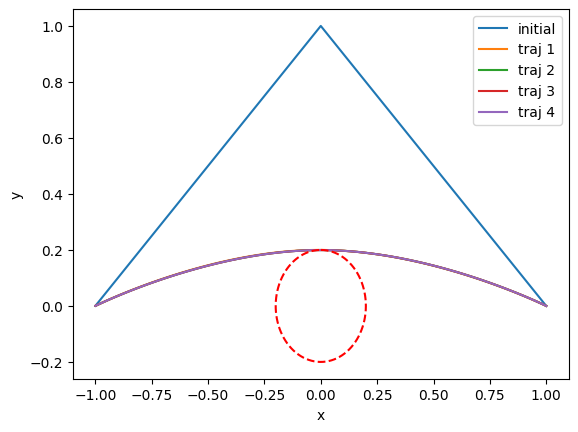

In [10]:
x0 = np.array([-1.0, 0., 0., 0.])
xf = np.array([1.0, 0., 0., 0.])
tf = 10
r = 1.0/5.0
dt = 0.1
trust_region = 2.
obs = np.array([5.*0.0, 0.])

# initial trajectory
last_x = np.zeros((len(x0), int(tf/dt)+1))
last_x[0, :] = np.linspace(-1.0, 1.0, int(tf/dt)+1)
last_x[2, :] = np.linspace(0.0, 2.0, int(tf/dt)+1)
for i in range(int(tf/dt)+1):
    if last_x[2, i] > 1.0:
        last_x[2, i] = 10./5.0 - last_x[2, i]

# SCP loop
plt.plot(last_x[0, :], last_x[2, :])
for i in range(4):
    x, u = solver(x0, xf, tf, r, obs, dt, last_x, R=trust_region)
    plt.plot(x[0, :], x[2, :])
    last_x = x
plt.legend(['initial', 'traj 1', 'traj 2', 'traj 3', 'traj 4'])
theta = np.linspace(0, 2*np.pi, 200)
plt.plot(obs[0]+r*np.sin(theta), obs[1]+r*np.cos(theta), 'r', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# save the trajectory and control
np.save('x.npy', x)
np.save('u.npy', u)

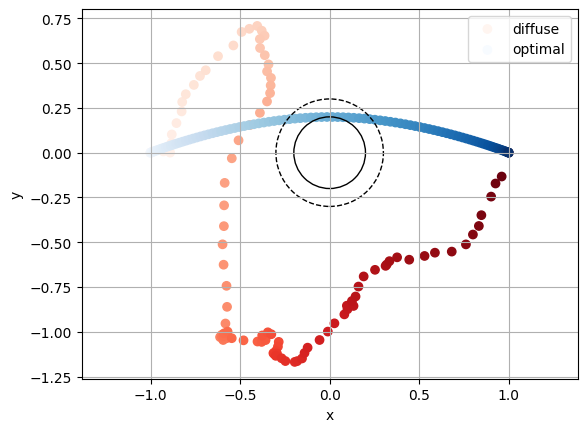

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# load the trajectory and control
x_optimal = np.load('x.npy')
y_optimal = np.load('u.npy')
x_diffuse = np.load('../x_traj.npy')
y_diffuse = np.load('../u_traj.npy')

# plot the trajectory
plt.scatter(
        x_diffuse[:, 0],
        x_diffuse[:, 1],
        label="diffuse",
        c=range(100),
        cmap="Reds",
        marker="o",
        alpha=1.0,
    )
plt.scatter(
    x_optimal[0],
    x_optimal[2],
    label="optimal",
    c=range(101),
    cmap="Blues",
    marker="o",
    alpha=1.0,
)
# set equal aspect ratio
plt.axis("equal")
# plot circle at [0, 0]
circle = plt.Circle((0, 0), 0.2, color="black", fill=False)
plt.gca().add_artist(circle)
circle = plt.Circle((0, 0), 0.3, color="black", fill=False, linestyle="--")
plt.gca().add_artist(circle)
# set grid
plt.grid()
# set labels
plt.xlabel("x")
plt.ylabel("y")
plt.legend()